In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# 의사결정나무 (Classification)

In [2]:
df_raw = pd.read_csv('./유방암.csv',encoding='cp949')
df_raw

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.14910,0.33310,0.33270,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.14360,0.12570,0.10470,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.12340,0.24450,0.35380,0.15710,0.3206,0.06938
3,양성,14.92,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,0.1687,...,17.18,18.22,112.00,906.6,0.10650,0.27910,0.31510,0.11470,0.2688,0.08273
4,양성,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,음성,19.55,23.21,128.90,1174.0,0.10100,0.13180,0.18560,0.10210,0.1989,...,20.82,30.44,142.00,1313.0,0.12510,0.24140,0.38290,0.18250,0.2576,0.07602
316,음성,19.10,26.29,129.10,1132.0,0.12150,0.17910,0.19370,0.14690,0.1634,...,20.33,32.72,141.30,1298.0,0.13920,0.28170,0.24320,0.18410,0.2311,0.09203
317,음성,24.25,20.20,166.20,1761.0,0.14470,0.28670,0.42680,0.20120,0.2655,...,26.02,23.99,180.90,2073.0,0.16960,0.42440,0.58030,0.22480,0.3222,0.08009
318,음성,19.17,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,...,20.96,29.94,151.70,1332.0,0.10370,0.39030,0.36390,0.17670,0.3176,0.10230


### 결측치 측정

In [3]:
df_raw.isnull().sum(axis=0)

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

- 결측치가 없다

### 목표변수 설정 및 data split

In [4]:
df_raw_y = df_raw['diagnosis']
df_raw_x = df_raw.drop("diagnosis",axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                             test_size=0.4,
                                                             random_state=1234)

- train 60% test 40% 로 split 한다.

### 기본옵션으로 모델 생성 및 score 출력

In [5]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)
print(tree_uncustomized.score(df_train_x,df_train_y))
print(tree_uncustomized.score(df_test_x,df_test_y))

1.0
0.8828125


- train score 는 100% 로 training data에 over fitting 돼있다고 할 수 있지만 unseen data인 test data의 score 도 88% 로 나쁘지만은 않다
- test score 는 약 88%의 정확도를보였다. 높은 정확도여서 어느 정도 개선이 될지 의문이 된다.

### max depth 조정

In [6]:
train_accuracy = []; test_accuracy=[]

para_depth = [depth *1 for depth in range(1,10)]

for v_max_depth in para_depth :
    tree = DecisionTreeClassifier(max_depth=v_max_depth,random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainScore']= train_accuracy
df_accuracy_depth['TestScore']= test_accuracy  

In [7]:
df_accuracy_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.932,0.852
1,2,0.979,0.875
2,3,0.995,0.875
3,4,1.000,0.883
4,5,1.000,0.883
5,6,1.000,0.883
6,7,1.000,0.883
7,8,1.000,0.883
8,9,1.000,0.883


findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.


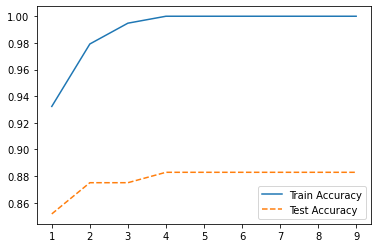

In [8]:
plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Accuracy")
plt.legend()

- 결과에 depth=4일때 train, test가 최대가 되는 최소지점이지만 train이 1.0 -> 오버피팅이 예상되어 depth=3 으로 정한다.

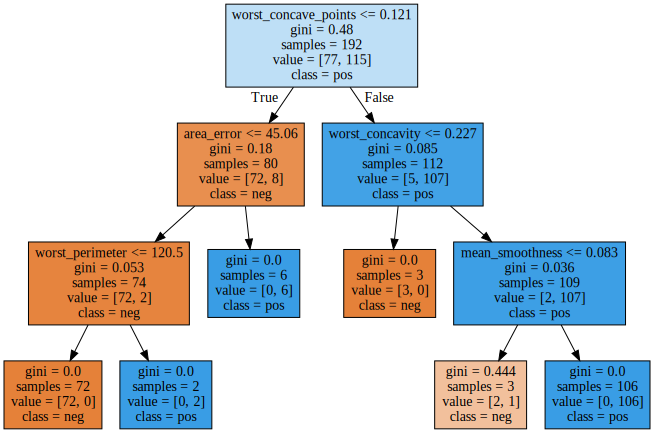

In [9]:
v_feature_name=df_train_x.columns
tree_low = DecisionTreeClassifier(max_depth=3,random_state=1234)
tree_low.fit(df_train_x,df_train_y)
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["neg","pos"],
               feature_names=v_feature_name,impurity=True, filled=True)
with open('tree_low.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split

In [10]:
train_score = []; test_score=[]
para_split = [n_split*10 for n_split in range(1,11)]
for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(max_depth=3,
                                  min_samples_split=v_min_samples_split,random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

In [11]:
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score

In [12]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.995,0.875
1,20,0.995,0.875
2,30,0.995,0.875
3,40,0.995,0.875
4,50,0.995,0.875
5,60,0.995,0.875
6,70,0.995,0.875
7,80,0.984,0.867
8,90,0.953,0.844
9,100,0.953,0.844


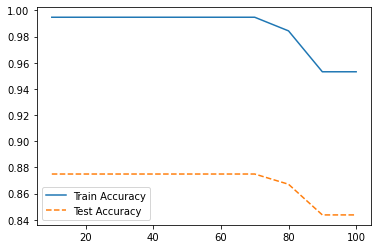

In [13]:
plt.plot(para_split, train_score, linestyle="-", label = 'Train Accuracy')
plt.plot(para_split, test_score, linestyle="--", label = 'Test Accuracy')
plt.legend()

- 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소한다.
- min samples split 의 수는 test,train accuracy가 낮아지기 전 가장 높을 때인 70을 선택

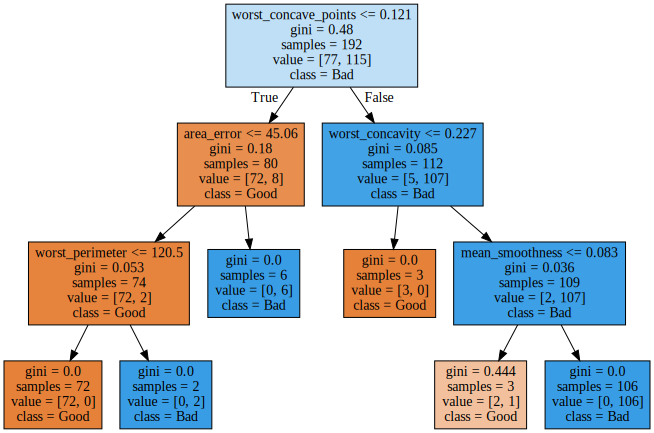

In [14]:
v_feature_name=df_train_x.columns
tree_low = DecisionTreeClassifier(max_depth=3,
                                  min_samples_split=70,random_state=1234)
tree_low.fit(df_train_x,df_train_y)
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good","Bad"],
               feature_names=v_feature_name,impurity=True, filled=True)
with open('tree_low.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 잎사귀 노드 수

In [15]:
train_score = []; test_score=[]
para_leaf = [n_leaf*1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=70,
                                 random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

In [16]:
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore']=test_score

In [17]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.995,0.875
1,2,0.995,0.875
2,3,0.990,0.883
3,4,0.974,0.859
4,5,0.969,0.859
5,6,0.964,0.859
6,7,0.958,0.898
7,8,0.958,0.898
8,9,0.958,0.898
9,10,0.953,0.914


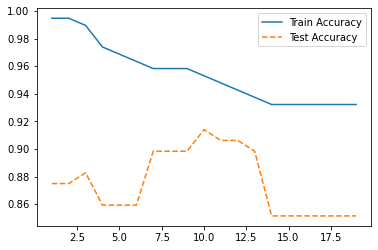

In [18]:
plt.plot(para_leaf, train_score, linestyle="-", label = 'Train Accuracy')
plt.plot(para_leaf, test_score, linestyle="--", label = 'Test Accuracy')
plt.legend()

- 잎사귀 노드의 최소 자료 수는 10으로 선택

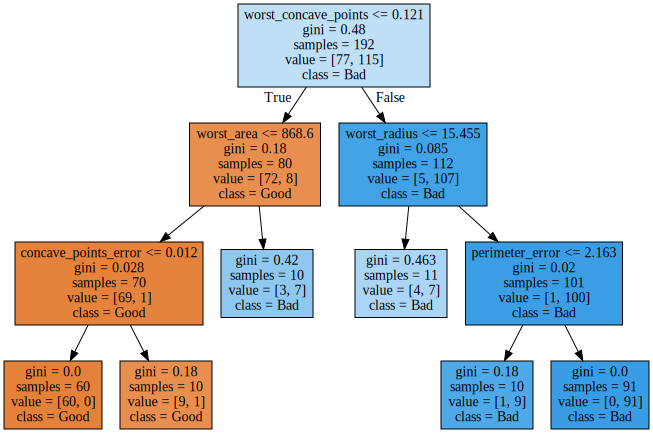

In [19]:
v_feature_name=df_train_x.columns
tree_low = DecisionTreeClassifier(max_depth=3, min_samples_split=70,
                                 random_state=1234, min_samples_leaf=10)
tree_low.fit(df_train_x,df_train_y)
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good","Bad"],
               feature_names=v_feature_name,impurity=True, filled=True)
with open('tree_low.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 설명변수

In [20]:
# v_feature_name = df_train_x.columns
# df_importance = pd.DataFrame()
# df_importance['Feature'] = v_feature_name
# df_importance['Importance'] = tree_final.feature_importances_
# df_importance.sort_values('Importance',ascending=False,inplace=True)
# df_importance.round(3)

NameError: name 'tree_final' is not defined

In [21]:
# df_importance.sort_values('Importance',ascending=True,inplace=True)
# coordinates=range(len(df_importance))
# plt.barh(y=coordinates,width=df_importance['Importance'])
# plt.yticks(coordinates,df_importance['Feature'])

KeyError: 'Importance'

#### 설명변수가 높은 상위 2개는 다음과 같다.
1. worst_concave_points : (세포)최대 오목한 점의 수
2. worst_area : (세포)최대 면적
유방암 진단에 위와 같은 설명변수를 사용할 수 있을 것이다.

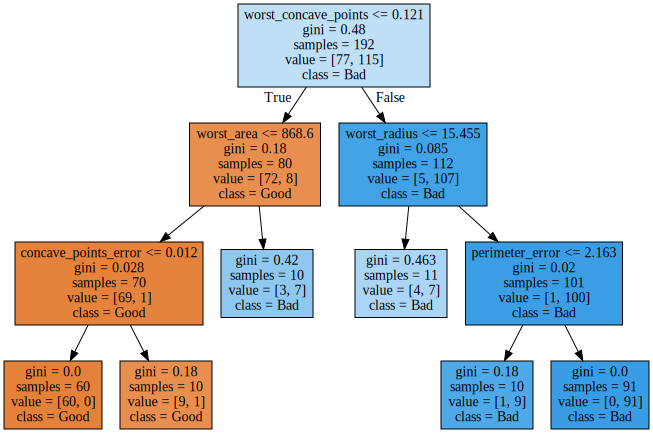

In [23]:
export_graphviz(tree_final, out_file='tree_final.dot',class_names=['Good','Bad'],
               feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 최종 결과

In [22]:
tree_final = DecisionTreeClassifier(max_depth=3, min_samples_split=70,
                                 random_state=1234, min_samples_leaf=10)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=70,
                       random_state=1234)

In [21]:
print(tree_final.score(df_train_x,df_train_y))
print(tree_final.score(df_test_x,df_test_y))

0.953125
0.9140625


- train accuracy는 100 -> 95.3 으로 하락하여 오버피팅이 어느정도 해소되었음을 볼 수 있고
- test accuracy는 88.3 -> 91.4 로 향상하여 모델의 성능이 상승하였음을 알 수 있다.
- 어제의 보고서 중 79->80%로 모델 성능이 향상되었다는 것에 대해 그정도의 성능향상은 높은 수치가 아니고 랜덤으로 변화할 수도 있는 수치이므로 적절하지 못하다는 피드백을 받았다. (79->80 의 향상과 98->99 는 다르다)
- 하지만 의사결정나무에서의 88-> 91의 약 3% 상승은 유의미 하다고 생각한다고 결론내었다.

# 랜덤 포레스트 (Classification)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
df_raw = pd.read_csv('./유방암.csv',encoding='cp949')
df_raw

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.14910,0.33310,0.33270,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.14360,0.12570,0.10470,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.12340,0.24450,0.35380,0.15710,0.3206,0.06938
3,양성,14.92,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,0.1687,...,17.18,18.22,112.00,906.6,0.10650,0.27910,0.31510,0.11470,0.2688,0.08273
4,양성,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,음성,19.55,23.21,128.90,1174.0,0.10100,0.13180,0.18560,0.10210,0.1989,...,20.82,30.44,142.00,1313.0,0.12510,0.24140,0.38290,0.18250,0.2576,0.07602
316,음성,19.10,26.29,129.10,1132.0,0.12150,0.17910,0.19370,0.14690,0.1634,...,20.33,32.72,141.30,1298.0,0.13920,0.28170,0.24320,0.18410,0.2311,0.09203
317,음성,24.25,20.20,166.20,1761.0,0.14470,0.28670,0.42680,0.20120,0.2655,...,26.02,23.99,180.90,2073.0,0.16960,0.42440,0.58030,0.22480,0.3222,0.08009
318,음성,19.17,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,...,20.96,29.94,151.70,1332.0,0.10370,0.39030,0.36390,0.17670,0.3176,0.10230


In [26]:
df_raw.isnull().sum(axis=0)

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

- 결측치가 존재하지 않고 더미변수를 생성할 데이터도 존재하지 않는다.

### train_test_split

In [27]:
df_raw_y = df_raw['diagnosis']
df_raw_x = df_raw.drop("diagnosis",axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                             test_size=0.3,
                                                             random_state=1234)

In [28]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x,df_train_y)
print(rf_uncustomized.score(df_train_x,df_train_y))
print(rf_uncustomized.score(df_test_x,df_test_y))

y_pred=rf_uncustomized.predict(df_test_x)
print(confusion_matrix(df_test_y,y_pred))

1.0
0.9375
[[21  3]
 [ 3 69]]


- train data를 대상으로 한 모델 정확도가 100% 여서 train data에 오버피팅이 되어있음을 알 수 있다.

- 또한 결과와 비교해보기 위해 confusion maxtrix를 생성해보았다.
   - 암을 암이 아니라고 예측하는 경우가 3개, 반대의 경우도 3개로 총 6개의 오류가 발생하였다.

### 트리수 변경에 따른 모델 성능

In [29]:
train_accuracy = []; test_accuracy=[]

para_n_tree = [n_tree*1 for n_tree in range(1,100)]
for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuarcy']=train_accuracy
df_accuracy_n['TestAccuracy']=test_accuracy

In [30]:
df_accuracy_n.round(3) # 설명력 확인

,n_estimators,TrainAccuarcy,TestAccuracy
0,1,0.978,0.896
1,2,0.987,0.896
2,3,0.987,0.875
3,4,0.991,0.885
4,5,0.991,0.875
...,...,...,...
94,95,1.000,0.938
95,96,1.000,0.938
96,97,1.000,0.927
97,98,1.000,0.927


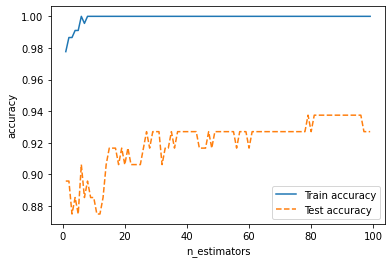

In [31]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = 'Train accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = 'Test accuracy')
plt.ylabel('accuracy'); plt.xlabel('n_estimators') # estimators : 추정량
plt.legend()

### - 트리수를 결정하는 중 train accuracy는 빠르게 100%에 수렴하였다.
- test accuracy가 어느정도 궤도에 오른 후인 30을 선택해 주었다.

#### 트리 수 변경에 따른 oob error 변화

In [32]:
oob_error = []
for v_n_estimator in range(1,151):
    rf=RandomForestClassifier(n_estimators = v_n_estimator, oob_score=True,
                              random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1-rf.oob_score_)

/home/piai/anaconda3/envs/yunsu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/envs/yunsu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/piai/anaconda3/envs/yunsu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/envs/yunsu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/piai/anaconda3/envs/yunsu/lib/python3.6/site-packages/sklearn/

#### 트리 수 변화에 따른 oob 에러의 변화를 시각화

Text(0.5, 0, 'n_estimators')

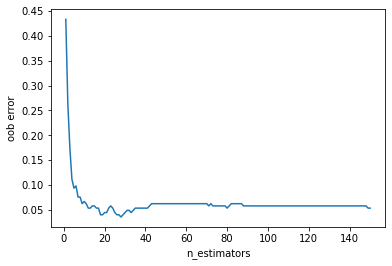

In [33]:
plt.plot(range(1,151),oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

- 트리 수 증가에 따라 모델의 정확도는 증가하는 경항을 보였고 OOB error는 20~40 에서 최소를 기록하고 이후 약간 상승 후 유지되었다.
- 가장 error가 적은 30을 트리 수로 선택하였다.
- 결국 정확도 측면과 error 측면에서 모두 30을 선택함을 알 수 있다.

### 최대 깊이 변경에 따른 모델 성능

In [34]:
train_accuracy = []; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(random_state=1234, n_estimators=30, max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainScore'] = train_accuracy
df_accuracy_depth['TestScore'] = test_accuracy

In [35]:
df_accuracy_depth.round(3) # 설명력 확인

,Depth,TrainScore,TestScore
0,1,0.951,0.896
1,2,0.978,0.885
2,3,0.987,0.917
3,4,1.000,0.906
4,5,1.000,0.927
5,6,1.000,0.927
6,7,1.000,0.927
7,8,1.000,0.927
8,9,1.000,0.927
9,10,1.000,0.927


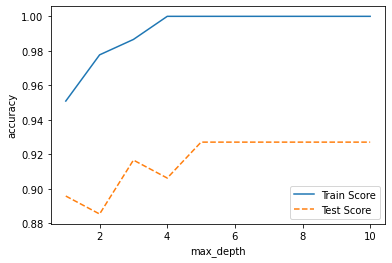

In [36]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = 'Train Score')
plt.plot(para_depth, test_accuracy, linestyle="--", label = 'Test Score')
plt.ylabel('accuracy'); plt.xlabel('max_depth') # estimators : 추정량
plt.legend()

- test score가 최대에 오른 후인 5를 선택해주었다.

### 분리노드의 최소자료 수 변경에 따른 모델 성능

In [37]:
train_score = []; test_score=[]

para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(random_state=1234, max_depth = 5, n_estimators=30,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score   

In [38]:
df_score_split.round(3) # 설명력 확인

,MinSamplesSplit,TrainScore,TestScore
0,10,0.991,0.917
1,20,0.982,0.917
2,30,0.982,0.917
3,40,0.978,0.906
4,50,0.978,0.885
5,60,0.964,0.865
6,70,0.951,0.865
7,80,0.964,0.865
8,90,0.955,0.896
9,100,0.951,0.896


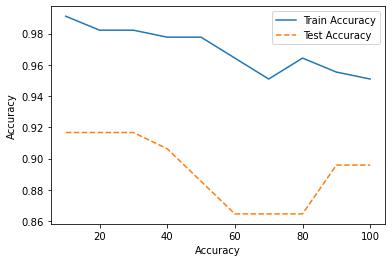

In [39]:
plt.plot(para_split, train_score, linestyle="-", label = 'Train Accuracy')
plt.plot(para_split, test_score, linestyle="--", label = 'Test Accuracy')
plt.ylabel('Accuracy'); plt.xlabel('Accuracy') # estimators : 추정량
plt.legend()

- 30까지는 같은 test accuracy를 보이고 train Score는 점차 줄어든다.
- 이에 Train accuracy와 test accuracy간 차이를 줄이기 위해 30을 선택하였다.

### 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [40]:
train_score = []; test_score=[]

para_n_leaf = [n_leaf*10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(random_state=1234, max_depth = 5, n_estimators=30,
                                min_samples_split = 30, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score

In [41]:
df_score_leaf.round(3) # 설명력 확인

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.982,0.917
1,2,0.978,0.896
2,3,0.978,0.906
3,4,0.978,0.885
4,5,0.978,0.906
5,6,0.973,0.906
6,7,0.973,0.885
7,8,0.973,0.896
8,9,0.973,0.885
9,10,0.973,0.885


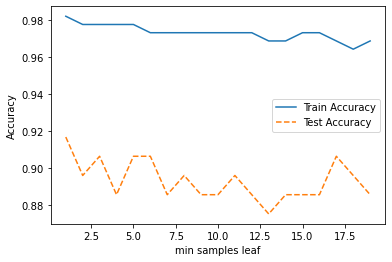

In [42]:
plt.plot(para_leaf, train_score, linestyle="-", label = 'Train Accuracy')
plt.plot(para_leaf, test_score, linestyle="--", label = 'Test Accuracy')
plt.ylabel('Accuracy'); plt.xlabel('min samples leaf') # estimators : 추정량
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도가 조금씩 감소하는 것을 볼 수 있었다.
- test Accuracy가 일정하게 유지되면서 && train accuracy와의 차이가 상대적으로 적고 && test accuracy가 높은 지점을 찾아본 결과 5로 결정할 수 있었다. 

### 설명변수

In [44]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
7,mean_concave_points,0.151
6,mean_concavity,0.141
27,worst_concave_points,0.114
3,mean_area,0.109
20,worst_radius,0.101
22,worst_perimeter,0.092
23,worst_area,0.056
2,mean_perimeter,0.049
5,mean_compactness,0.030
12,perimeter_error,0.027


([<matplotlib.axis.YTick at 0x7f56bcf90748>,
 [Text(0, 0, 'mean_texture'),
  Text(0, 1, 'worst_fractal_dimension'),
  Text(0, 2, 'worst_smoothness'),
  Text(0, 3, 'texture_error'),
  Text(0, 4, 'concavity_error'),
  Text(0, 5, 'symmetry_error'),
  Text(0, 6, 'smoothness_error'),
  Text(0, 7, 'fractal_dimension_error'),
  Text(0, 8, 'worst_symmetry'),
  Text(0, 9, 'mean_fractal_dimension'),
  Text(0, 10, 'worst_compactness'),
  Text(0, 11, 'mean_smoothness'),
  Text(0, 12, 'radius_error'),
  Text(0, 13, 'compactness_error'),
  Text(0, 14, 'mean_radius'),
  Text(0, 15, 'worst_texture'),
  Text(0, 16, 'mean_symmetry'),
  Text(0, 17, 'concave_points_error'),
  Text(0, 18, 'area_error'),
  Text(0, 19, 'worst_concavity'),
  Text(0, 20, 'perimeter_error'),
  Text(0, 21, 'mean_compactness'),
  Text(0, 22, 'mean_perimeter'),
  Text(0, 23, 'worst_area'),
  Text(0, 24, 'worst_perimeter'),
  Text(0, 25, 'worst_radius'),
  Text(0, 26, 'mean_area'),
  Text(0, 27, 'worst_concave_points'),
  Text(0, 2

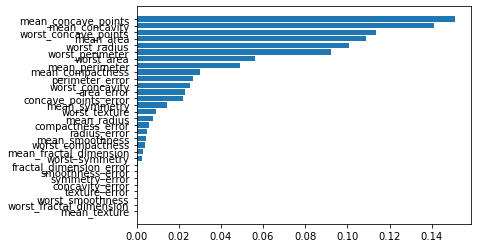

In [45]:
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])

#### 설명변수가 높은 상위 5개는 다음과 같다.
1. mean_concave_points : (세포)평균 오목한 점의 수
2. mean_concavity : (세포)평균 오목함
3. worst_concave_points : (세포)최대 오목한 점의 수
4. mean_area : (세포)최대 면적
5. worst_radius : (세포)최대 반경
유방암 진단에 위와 같은 설명변수를 사용할 수 있을 것이다.

### 최종모델 선택

In [43]:
rf_final = RandomForestClassifier(random_state=1234, max_depth = 5, n_estimators=30,
                                min_samples_split = 30, min_samples_leaf=5)
rf_final.fit(df_train_x,df_train_y)
y_pred=rf_final.predict(df_test_x)
print(rf_final.score(df_train_x,df_train_y))
print(rf_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9776785714285714
0.90625
[[20  4]
 [ 5 67]]


- 최종적으로 train acc : 100 -> 97.7 test acc : 93.9 -> 90.6 으로 정확도가 하향했다.
confusion matrix 분석 시 이전과 비교하면
- 암일 경우를 암이 아닌 경우로 분류하는 횟수 3->5 회
- 반대의 경우가 3-> 4회로 확연히 성능이 줄어든 것을 알 수 있었다.